In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import csv
import scipy.optimize

# List of models available for usage
models_list = ["Ornstein–Uhlenbeck", "Black-Scholes", "Vasicek", "Cox-Ingersoll-Ross", "RB",  "Ho-Lee",  "Hull-White"]

class Euler_Maruyama_scheme:
    def __init__(self,model, params, t_start, t_end, n_steps):
        self.model = model
        # Parameters of the model
        self.initial_mu = params["mu"]
        self.initial_sigma = params["sigma"]
        self.initial_theta = params["theta"]
        # y_0 - y at the start of the simulation 
        self.y_start = params["y_start"]
        # Start and end of considered time interval
        self.t_start = t_start
        self.t_end = t_end
        # Number of steps in simulation
        self.n_steps = n_steps
        # If user chooses model which is not in the list then we exit class
        if not self.model in models_list:
            print("This model is not in the list.")
            # Exit class
            sys.exit(0)

    # Generate mu (a(r_t,t)) in Euler - Maruyama scheme, according to chosen model
    def generate_mu(self, y):
        match self.model:
            case "Black-Scholes":
                return self.initial_mu
            case "Ornstein–Uhlenbeck":
                return self.initial_theta * (self.initial_mu - y)
            case "Vasicek":
                return self.initial_theta - self.initial_mu * y
            case "Cox-Ingersoll-Ross":
                return self.initial_theta - self.initial_mu * y
            case "RB":
                return self.initial_theta* y
            case "Ho-Lee":
                return self.initial_theta
            case "Hull-White":
                return self.initial_theta - self.initial_mu * y

    # Generate sigma (b(r_t,t)) in Euler - Maruyama scheme, according to chosen model
    def generate_sigma(self, y):
        match self.model:
            case "Black-Scholes":
                return self.initial_sigma
            case "Ornstein–Uhlenbeck":
                return self.initial_sigma
            case "Vasicek":
                return self.initial_sigma
            case "Cox-Ingersoll-Ross":
                return self.initial_sigma * np.sqrt(y)
            case "RB":
                return self.initial_sigma * y
            case "Ho-Lee":
                return self.initial_sigma 
            case "Hull-White":
                return self.initial_sigma

    # Increments of Wiener process 
    def dW(self, delta_t):
        return np.random.normal(loc=0.0, scale=np.sqrt(delta_t))

    def calibrate_params(self, given_data, initial_params):

        def objective(params):
            # Write initial parameters as given parameters for the purpose of simulations
            self.initial_mu, self.initial_sigma, self.initial_theta, self.y_start = params
            # Run one simulation and save generated values to simulated data
            simulated_data = self.run_simulation(self.t_start, self.t_end, len(np.mean(given_data, axis = 1)) - 1, self.y_start)[1]
            simulated_means = np.mean(simulated_data)
            # Calculate mean squared error
            return np.mean((np.mean(given_data, axis = 1) - simulated_data) ** 2)

        # Params is a dictionary, and for the minimize function we need just values, so we create vector of just values
        initial_params_values = [initial_params["mu"], initial_params["sigma"], initial_params["theta"], initial_params["y_start"]]
        # Minimize the objective function (mean squared error) and save the result
        result = scipy.optimize.minimize(objective, initial_params_values, method = "Powell")
        # Save the parameters as those value, which minimize the objective function
        self.initial_mu, self.initial_sigma, self.initial_theta, self.y_start = result.x
        return result.x

    def run_simulation(self, t_start, t_end, n_steps, y_start = None):
        # If we don't specify the y_start then we use self.y_start
        if y_start == None:
            y_start = self.y_start

        # Length of a step
        delta_t = float(t_end - t_start)/ n_steps
        # Vector of steps
        t_range = np.arange(t_start, t_end + delta_t, delta_t)

        # Initiate vector of values
        y_values = np.zeros(t_range.size)
        y_values[0] = y_start
        for i in range(1, t_range.size):
            # Calculate y_values according to Euler - Maruyama scheme
            t = t_start + (i - 1) * delta_t
            y = y_values[i - 1]
            y_values[i] = y + self.generate_mu(y) * delta_t + self.generate_sigma(y) * self.dW(delta_t)

        return t_range, y_values
        
    def plot_simulations(self,n_sims, t_start, t_end, n_steps, y_start = None):
        # If we don't specify the y_start then we use self.y_start
        if y_start == None:
            y_start = self.y_start

        # Repeat run_simulation n_sims times, and plot every result
        for i in range(n_sims):
            result = self.run_simulation(t_start, t_end, n_steps, y_start)
            plt.plot(result[0], result[1])

        # Set labels to "time", and "y"
        plt.xlabel("time")
        plt.ylabel("y")
        plt.show()

    # Assuming option expires at t_end
    # Spot price is y_start, so we don't use it as a parameter here
    def calculate_option_price(self, call_put, strike, n_simulations):
        simulated_data = np.zeros(n_simulations)
        for i in range(n_simulations):
            # Saving last element of simulation, S_{n}
            simulated_data[i] = self.run_simulation(self.t_start, self.t_end, self.n_steps, self.y_start)[1][-1]

        # Calculating profit for each iteraion and taking mean value
        if call_put == "call":
            simulated_data_0 = np.array([simulated_data - strike, np.zeros(n_simulations)])
            return(np.mean(simulated_data_0.max(axis = 0)))
        elif call_put == "put":
            simulated_data_0 = np.array([strike - simulated_data, np.zeros(n_simulations)])
            return(np.mean(simulated_data_0.max(axis = 0)))
        else:
            print("Wrong call_put value")

    def calculate_barrier_option_price(self, call_put, strike, n_simulations, barrier_one_type = None, barrier_one_value = None, barrier_two_type = None, barrier_two_value = None):

        # Initiate empty array and vector
        simulated_data = np.empty(shape=(n_simulations, n_steps + 1), dtype='object')
        profit = np.zeros(n_simulations)
        for i in range(n_simulations):
            # Saving y_values as simulated_data for current simulation
            simulated_data[i,] = (self.run_simulation(self.t_start, self.t_end, self.n_steps, self.y_start)[1])

            # If we have barrier option we check if the option will return any value, or is it worthless
            # We either save value of profit as 0, or we save flag as 0. Later if flag is 0 we calculate the profit using call or put formulas
            flag = 1
            match barrier_one_type:
                case "up_and_out":
                    if simulated_data[i,].max() > barrier_one_value:
                        profit[i] = 0
                case "up_and_in":
                    if simulated_data[i,].max() < barrier_one_value:
                        profit[i] = 0
                case "down_and_out":
                    if simulated_data[i,].min() < barrier_one_value:
                        profit[i] = 0
                case "down_and_in":
                    if simulated_data[i,].min() > barrier_one_value:
                        profit[i] = 0
                case _:
                    flag = 0
    
            match barrier_two_type:
                case "up_and_out":
                    if simulated_data[i,].max() > barrier_two_value:
                        profit[i] = 0
                case "up_and_in":
                    if simulated_data[i,].max() < barrier_two_value:
                        profit[i] = 0
                case "down_and_out":
                    if simulated_data[i,].min() < barrier_two_value:
                        profit[i] = 0
                case "down_and_in":
                    if simulated_data[i,].min() > barrier_two_value:
                        profit[i] = 0
                case _:
                    flag = 0

            if flag == 0:
                if call_put == "call":
                    profit[i] = max(simulated_data[i,-1] - strike,0)
                elif call_put == "put":
                    profit[i] = max(strike - simulated_data[i,-1],0)
                else:
                    print("Wrong call_put value")
        return np.mean(profit)
    

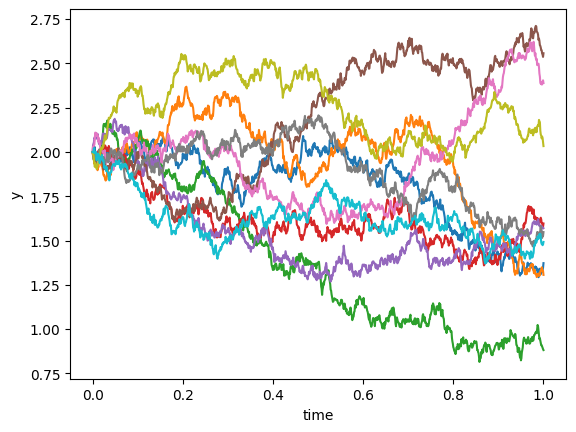

In [2]:
params = {"mu": 0,
         "sigma":0.5,
         "theta":0.05,
         "y_start": 2}

t_start = 0
t_end = 1
n_steps = 1000
n_simulations = 10
model = Euler_Maruyama_scheme(models_list[0],params, t_start, t_end, n_steps)
model.plot_simulations(n_simulations,t_start,t_end,n_steps,params["y_start"])

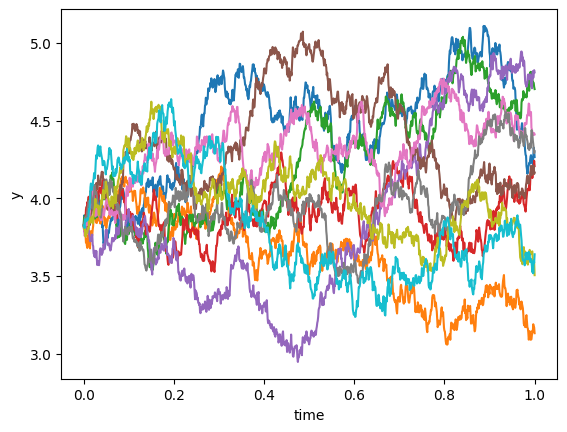

In [3]:
data_array = []
with open("Data/spots-monthly.csv") as csv_file:
    data_csv = csv.reader(csv_file, delimiter=',')
    for row in data_csv:
        data_array.append(row)

data_array = np.array(data_array)

data_array_no_date = data_array[1:,1:]
data_array_no_date = data_array_no_date.astype(np.float32)

model.calibrate_params(data_array_no_date, params)
model.plot_simulations(n_simulations,t_start,t_end,n_steps)

In [4]:
price = model.calculate_barrier_option_price("call", 2, 1000, "up_and_out",3)
print(price)

2.076786978160101


In [5]:
print(model.calculate_option_price("put", 5, 1000))

0.86508671924177
